<a href="https://colab.research.google.com/github/CarolineTomasik/AANN-Final/blob/main/AANN_Final_simple_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
import sklearn
import xgboost as xgb
from xgboost import plot_importance
import sklearn.ensemble
import sklearn.model_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime
from datetime import date
from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_squared_error
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from scipy import stats

**upload csv**

In [32]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [5]:
url = 'https://raw.githubusercontent.com/CarolineTomasik/AANN-Final/main/listings.csv'
df = pd.read_csv(url)

In [23]:
df.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,x,y,z,rt_Hotel room,rt_Private room,rt_Shared room,n_Adams-Normandie,n_Agoura Hills,n_Agua Dulce,n_Alhambra,n_Alondra Park,n_Altadena,n_Angeles Crest,n_Arcadia,n_Arleta,n_Arlington Heights,n_Artesia,n_Athens,n_Atwater Village,n_Avalon,n_Avocado Heights,n_Azusa,n_Baldwin Hills/Crenshaw,n_Baldwin Park,n_Bel-Air,n_Bell,n_Bell Gardens,n_Bellflower,n_Beverly Crest,n_Beverly Grove,n_Beverly Hills,n_Beverlywood,n_Boyle Heights,n_Bradbury,...,n_Unincorporated Santa Monica Mountains,n_Unincorporated Santa Susana Mountains,n_Universal City,n_University Park,n_Val Verde,n_Valinda,n_Valley Glen,n_Valley Village,n_Van Nuys,n_Venice,n_Vermont Knolls,n_Vermont Square,n_Vermont Vista,n_Vermont-Slauson,n_Vernon,n_Veterans Administration,n_View Park-Windsor Hills,n_Vincent,n_Walnut,n_Watts,n_West Adams,n_West Carson,n_West Compton,n_West Covina,n_West Hills,n_West Hollywood,n_West Los Angeles,n_West Puente Valley,n_West Whittier-Los Nietos,n_Westchester,n_Westlake,n_Westlake Village,n_Westmont,n_Westwood,n_Whittier,n_Willowbrook,n_Wilmington,n_Windsor Square,n_Winnetka,n_Woodland Hills
0,0,115,30,2,1,0,-0.457475,-0.703853,0.543423,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,78,30,29,2,301,-0.457577,-0.769755,0.445085,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,155,1,21,2,335,-0.529208,-0.666298,0.525344,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,50,30,0,1,0,-0.233319,-0.740013,0.630827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,118,31,23,2,365,-0.488765,-0.758353,0.431287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31200 entries, 0 to 31542
Columns: 276 entries, neighbourhood_group to n_Woodland Hills
dtypes: float64(3), int64(6), uint8(267)
memory usage: 10.3 MB


In [12]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [9]:
#dropping because column is uninformative
df = df.drop(['id','name','host_id', 'host_name', 'host_name'], axis=1)

#dropping because many null values
df = df.drop(['last_review','reviews_per_month'], axis=1)

#removing price outliers
df = df[(np.abs(stats.zscore(df['price'])) < 3)]

In [20]:
#changing latitutde and longitude
df['x'] = np.cos(df['latitude'], dtype=np.float64) * np.cos(df['longitude'], dtype=np.float64)
df['y'] = np.cos(df['latitude'], dtype=np.float64) * np.sin(df['longitude'], dtype=np.float64)
df['z'] = np.sin(df['latitude'], dtype=np.float64)
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

**Neighbourhood group**

In [17]:
df.neighbourhood_group.value_counts()

City of Los Angeles     17462
Other Cities            11267
Unincorporated Areas     2471
Name: neighbourhood_group, dtype: int64

In [18]:
#combining other cities and unincorporated groups into one since there are so few of the latter
df.neighbourhood_group.replace({'City of Los Angeles': 1, 'Other Cities': 0, 'Unincorporated Areas':0}, inplace=True)

**One hot encoding for Neighbourhood and room type**

In [22]:
df = pd.get_dummies(df, prefix=['rt', 'n'], columns=['room_type', 'neighbourhood'], drop_first=True)

**Machine Learning Models**

In [25]:
scaler = MinMaxScaler()

X = df.drop('price', axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X.head()

,neighbourhood_group,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,x,y,z,rt_Hotel room,rt_Private room,rt_Shared room,n_Adams-Normandie,n_Agoura Hills,n_Agua Dulce,n_Alhambra,n_Alondra Park,n_Altadena,n_Angeles Crest,n_Arcadia,n_Arleta,n_Arlington Heights,n_Artesia,n_Athens,n_Atwater Village,n_Avalon,n_Avocado Heights,n_Azusa,n_Baldwin Hills/Crenshaw,n_Baldwin Park,n_Bel-Air,n_Bell,n_Bell Gardens,n_Bellflower,n_Beverly Crest,n_Beverly Grove,n_Beverly Hills,n_Beverlywood,n_Boyle Heights,n_Bradbury,n_Brentwood,...,n_Unincorporated Santa Monica Mountains,n_Unincorporated Santa Susana Mountains,n_Universal City,n_University Park,n_Val Verde,n_Valinda,n_Valley Glen,n_Valley Village,n_Van Nuys,n_Venice,n_Vermont Knolls,n_Vermont Square,n_Vermont Vista,n_Vermont-Slauson,n_Vernon,n_Veterans Administration,n_View Park-Windsor Hills,n_Vincent,n_Walnut,n_Watts,n_West Adams,n_West Carson,n_West Compton,n_West Covina,n_West Hills,n_West Hollywood,n_West Los Angeles,n_West Puente Valley,n_West Whittier-Los Nietos,n_Westchester,n_Westlake,n_Westlake Village,n_Westmont,n_Westwood,n_Whittier,n_Willowbrook,n_Wilmington,n_Windsor Square,n_Winnetka,n_Woodland Hills
0,0.0,0.025801,0.002281,0.000000,0.000000,0.351151,0.421490,0.667717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.025801,0.033067,0.003226,0.824658,0.351042,0.327177,0.585053,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.023945,0.003226,0.917808,0.274768,0.475236,0.652520,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.025801,0.000000,0.000000,0.000000,0.589838,0.369741,0.741190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.026690,0.026226,0.003226,1.000000,0.317832,0.343494,0.573455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y = df[['price']]
y = pd.DataFrame(scaler.fit_transform(y), columns=list(y.columns))
y.head()

,price
0,0.055907
1,0.037919
2,0.075352
3,0.024307
4,0.057365


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [28]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
training_preds_linreg = linreg.predict(X_train)
val_preds_linreg = linreg.predict(X_test)

print('Linear Regression Explained Variance Score:', round(explained_variance_score(y_test, val_preds_linreg),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_linreg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_linreg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_linreg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_linreg),4))

Linear Regression Explained Variance Score: -2.880069274572037e+23

Training MSE: 0.0095
Validation MSE: 3.4651497750965864e+21

Training r2: 0.2567
Validation r2: -2.8805308981134018e+23


In [29]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=30, random_state=0)
rf.fit(X_train, y_train.values.ravel())
training_preds_rf = rf.predict(X_train)
val_preds_rf = rf.predict(X_test)

print('Random Forest Explained Variance Score:', round(explained_variance_score(y_test, val_preds_rf),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_rf),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_rf),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_rf),4))
print("Validation r2:", round(r2_score(y_test, val_preds_rf),4))

Random Forest Explained Variance Score: 0.399

Training MSE: 0.0012
Validation MSE: 0.0072

Training r2: 0.9077
Validation r2: 0.3991


In [30]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print('XGB Explained Variance Score:', round(explained_variance_score(y_test, val_preds_xgb_reg),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[04:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Explained Variance Score: 0.343

Training MSE: 0.0082
Validation MSE: 0.0079

Training r2: 0.3555
Validation r2: 0.3426


In [33]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

,weight
rt_Private room,0.159123
n_Hollywood Hills West,0.111733
n_Malibu,0.083806
rt_Shared room,0.050985
y,0.049037
n_Beverly Crest,0.044330
neighbourhood_group,0.034691
availability_365,0.031730
x,0.029040
minimum_nights,0.023492


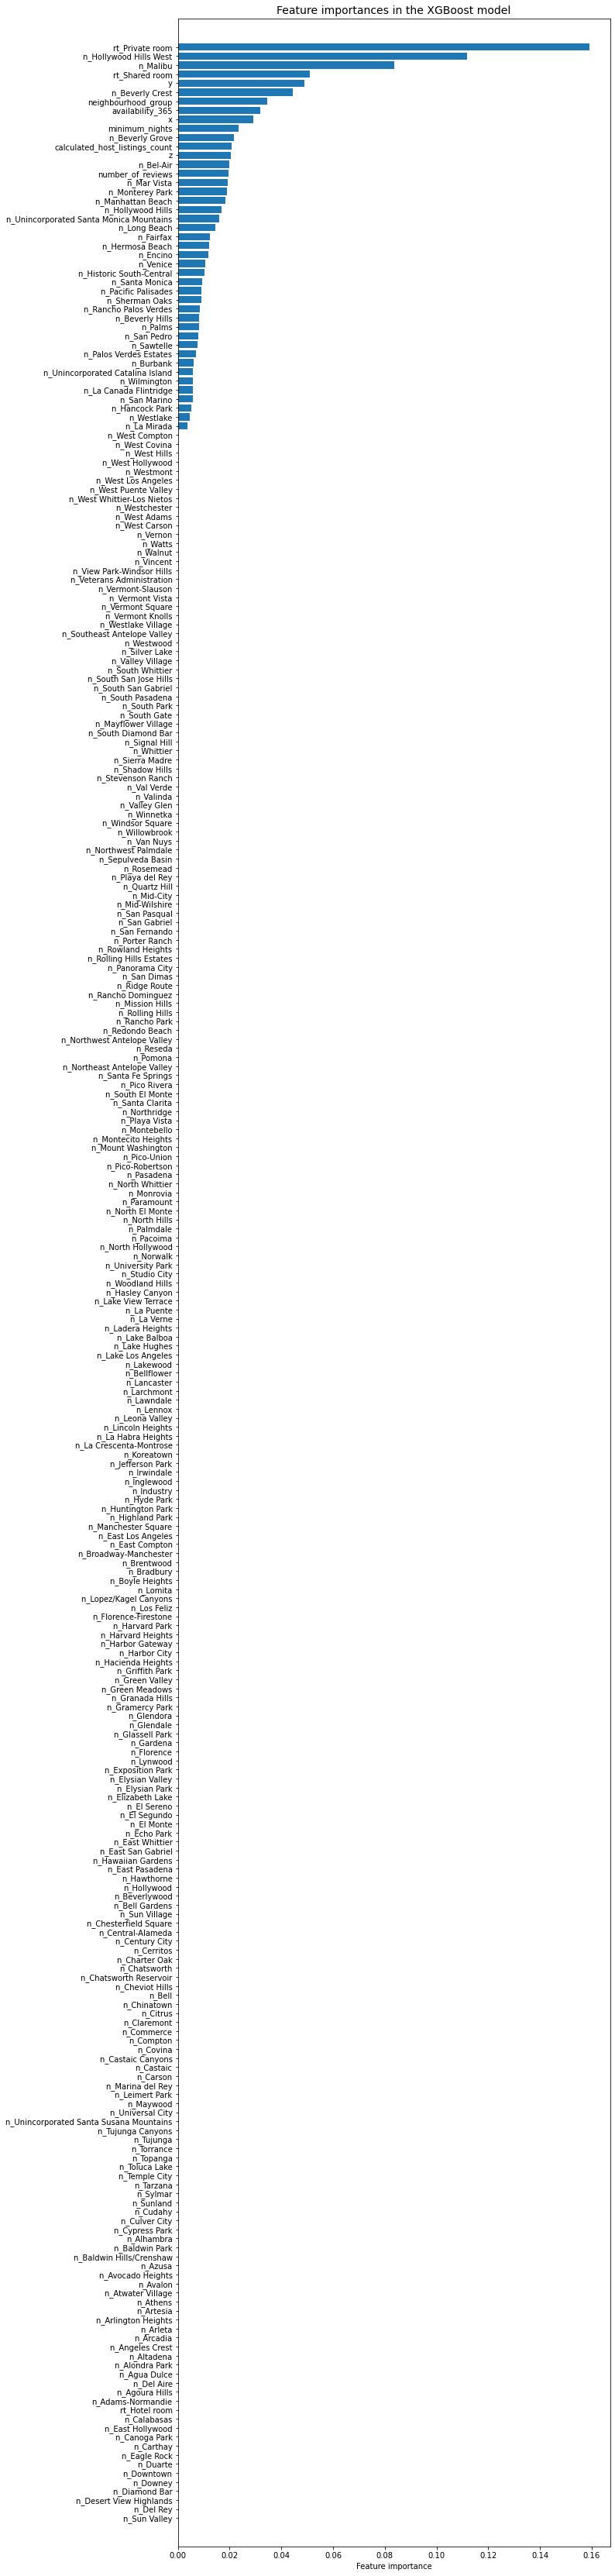

In [34]:
ft_weights_xgb_reg.sort_values('weight', inplace=True)
plt.figure(figsize=(10,60))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

**Model 1**

In [56]:
scaler = MinMaxScaler()

X = df.drop('price', axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

y = df[['price']]
y = pd.DataFrame(scaler.fit_transform(y), columns=list(y.columns))

dft = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
batch_size = 128

train_len = int(len(dft)*0.8)
val_len = len(dft) - train_len

train_ds, val_ds = random_split(dft, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

input_size = X.shape[1]
output_size = 1 #output is 1 because its a regression task


def evaluate(model, train_loader, val_loader):
    outputs_t = [model.validation_step(batch) for batch in train_loader]
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs_t, outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, train_loader, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.drop = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                
        loss = F.mse_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)           
        loss = F.mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs_t, outputs):
        batch_losses_t = [x['val_loss'] for x in outputs_t]
        epoch_loss_t = torch.stack(batch_losses_t).mean()
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'train_loss': epoch_loss_t.item(), 'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [57]:
model1 = Model()
evaluate(model1, train_loader, val_loader)
history1 = fit(100, 0.05, model1, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], val_loss: 0.0115
Epoch [1], val_loss: 0.0111
Epoch [2], val_loss: 0.0109
Epoch [3], val_loss: 0.0108
Epoch [4], val_loss: 0.0106
Epoch [5], val_loss: 0.0105
Epoch [6], val_loss: 0.0104
Epoch [7], val_loss: 0.0103
Epoch [8], val_loss: 0.0102
Epoch [9], val_loss: 0.0101
Epoch [10], val_loss: 0.0100
Epoch [11], val_loss: 0.0100
Epoch [12], val_loss: 0.0099
Epoch [13], val_loss: 0.0098
Epoch [14], val_loss: 0.0097
Epoch [15], val_loss: 0.0097
Epoch [16], val_loss: 0.0097
Epoch [17], val_loss: 0.0096
Epoch [18], val_loss: 0.0095
Epoch [19], val_loss: 0.0095
Epoch [20], val_loss: 0.0094
Epoch [21], val_loss: 0.0094
Epoch [22], val_loss: 0.0093
Epoch [23], val_loss: 0.0092
Epoch [24], val_loss: 0.0092
Epoch [25], val_loss: 0.0092
Epoch [26], val_loss: 0.0092
Epoch [27], val_loss: 0.0091
Epoch [28], val_loss: 0.0091
Epoch [29], val_loss: 0.0091
Epoch [30], val_loss: 0.0090
Epoch [31], val_loss: 0.0090
Epoch [32], val_loss: 0.0090
Epoch [33], val_loss: 0.0090
Epoch [34], val_loss: 0.

In [58]:
result1 = evaluate(model1, train_loader, val_loader)
result1

{'train_loss': 0.009083382785320282, 'val_loss': 0.008680676110088825}

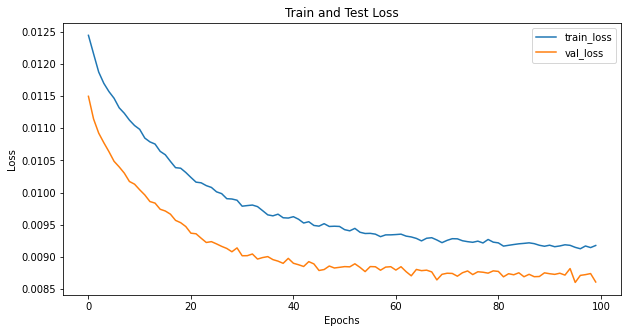

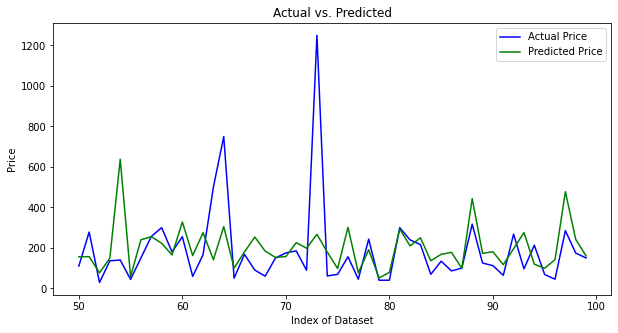

In [59]:
pd.DataFrame(history1).plot(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.show()


def predict_single(x, model1):
    xb = x.unsqueeze(0)
    return model1(x).item()

# Predicting on 50 datapoints
tar = []
pre = []
for i in range(50, 100):
    x, target = val_ds[i]
    pred = predict_single(x, model1)
    # print("Input: ", x)
    data = scaler.inverse_transform(np.array([target.item(), pred]).reshape(-1, 1)).tolist()
    tar.append(data[0][0])
    pre.append(data[1][0])

x_axis = np.arange(50, 100, 1)
plt.figure(figsize=(10, 5))
plt.xlabel("Index of Dataset")
plt.ylabel("Price")
plt.title("Actual vs. Predicted")
plt.plot(x_axis, tar, 'b', label="Actual Price")
plt.plot(x_axis, pre, 'g', label="Predicted Price")
plt.legend()
plt.show()